In [1]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

Start Position: x=0.0, y=0.0, z=20.0
End Position: x=239.99480980236157, y=-0.008994372534787241, z=14.006860886166852


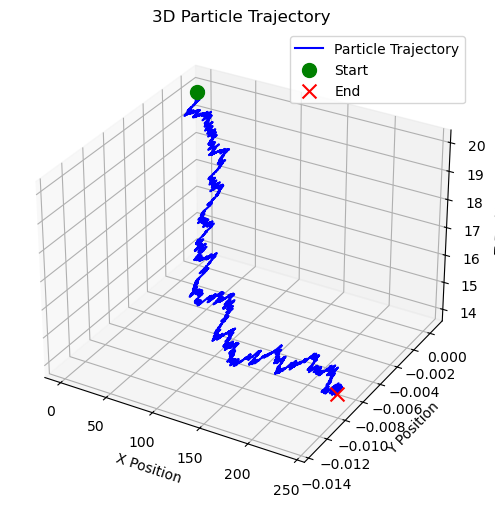

In [ ]:
# Define the velocity field 
uvec = np.array([4.0, 0.0, 0.0])

# Define the gravitational settling velocity 
ugvec = np.array([0.0, 0.0, -0.1])

# Initialize parameters
n_particles = 1  # Number of particles
dt = 0.01  # Time step
tfinal = 60
t = np.arange(0, tfinal + dt, dt)

# Initialize particle positions (all starting at the source location)
source_location = np.array([0.0, 0.0, 20.0])  # Source at (0, 0, 10)

# Precompute random fluctuations
np.random.seed(42)  # Fix seed for reproducibility
rx = np.random.uniform(-0.5, 0.5, size=len(t))
ry = np.random.uniform(-0.5, 0.5, size=len(t))
reta = np.random.uniform(-0.5, 0.5, size=len(t))

# Define the equations to integrate
def dispersion_deriv(pos, t0, u, u_g, rx, ry, reta):
    a = 0.5
    b = 0.875
    leta = 0.08
    wind_speed = np.sqrt(u[0]**2 + u[1]**2)
    
    # Pick random fluctuation at current time step
    t_idx = min(int(t0 / dt), len(rx) - 1)  #
    fluct_x = rx[t_idx] * a * (wind_speed * dt) ** b
    fluct_y = ry[t_idx] * a * (wind_speed * dt) ** b
    fluct_z = reta[t_idx] * leta

    return [u[0] + u_g[0] + fluct_x, 
            u[1] + u_g[1] + fluct_y, 
            u[2] + u_g[2] + fluct_z]

# Solve ODE for one particle
x_t = odeint(dispersion_deriv, source_location, t, args=(uvec, ugvec, rx, ry, reta))

# Extract x, y, z coordinates
x_vals = x_t[:, 0]
y_vals = x_t[:, 1]
z_vals = x_t[:, 2]

# Print start and end positions
print(f"Start Position: x={x_vals[0]}, y={y_vals[0]}, z={z_vals[0]}")
print(f"End Position: x={x_vals[-1]}, y={y_vals[-1]}, z={z_vals[-1]}")

# Create 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
ax.plot(x_vals, y_vals, z_vals, label="Particle Trajectory", color="b")

# Mark start and end points
ax.scatter(x_vals[0], y_vals[0], z_vals[0], color='g', marker='o', s=100, label="Start")  # Green start
ax.scatter(x_vals[-1], y_vals[-1], z_vals[-1], color='r', marker='x', s=100, label="End")  # Red end

# Labels and Title
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Z Position")
ax.set_title("3D Particle Trajectory")

# Show legend
ax.legend()
plt.show()


In [3]:
# Generate training dataset

# Define the velocity field (constant in this example)
uvec = np.array([4.0, 0.0, 0.0])

# Define the gravitational settling velocity (constant in this example)
ugvec = np.array([0.0, 0.0, -0.1])

# Initialize parameters
n_particles = 1  # Number of particles
dt = 0.01  # Time step
tfinal = 10
t = np.arange(0, tfinal + dt, dt)

# Generate random initial conditions
n_conditions = 100

# x and y between -50 and 50
x = np.random.uniform(-50, 50, n_conditions)
y = np.random.uniform(-50, 50, n_conditions)

# z between 0 and 50
z = np.random.uniform(0, 50, n_conditions)

# Stack into a 2D array where each row is an initial condition (x, y, z)
x0 = np.column_stack((x, y, z))

# Precompute random fluctuations
np.random.seed(42)  # Fix seed for reproducibility
rx = np.random.uniform(-0.5, 0.5, size=len(t))
ry = np.random.uniform(-0.5, 0.5, size=len(t))
reta = np.random.uniform(-0.5, 0.5, size=len(t))

# define the inputs and outputs for the neural networks
nninput = np.zeros((100*len(t)-1,3))
nnoutput = np.zeros((100*len(t)-1,3))

# Define the equations to integrate
def dispersion_deriv(pos, t0, u, u_g, rx, ry, reta):
    a = 0.5
    b = 0.875
    leta = 0.08
    wind_speed = np.sqrt(u[0]**2 + u[1]**2)
    
    # Pick random fluctuation at current time step
    t_idx = min(int(t0 / dt), len(rx) - 1)  # Ensure valid index
    fluct_x = rx[t_idx] * a * (wind_speed * dt) ** b
    fluct_y = ry[t_idx] * a * (wind_speed * dt) ** b
    fluct_z = reta[t_idx] * leta

    return [u[0] + u_g[0] + fluct_x, 
            u[1] + u_g[1] + fluct_y, 
            u[2] + u_g[2] + fluct_z]

# Solve ODE for one particle
x_t = np.asarray([odeint(dispersion_deriv, x0_j, t, args=(uvec, ugvec, rx, ry, reta))
                 for x0_j in x0])

# define the inputs and outputs for the neural networks
# First index is the simulation (1 for each initial condition), second index is timestep, third index is position
# Inputs would be all timesteps except the last one (:-1), outputs would be all except first timesteps (1:)
for j in range(100):
    nninput[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nnoutput[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]

In [4]:
nninput.shape

(100099, 3)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network architecture
class ParticleTrajectoryPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ParticleTrajectoryPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second fully connected layer
        self.fc3 = nn.Linear(hidden_dim, output_dim)  # Output layer
        self.activation = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.activation(self.fc1(x))  # Apply activation to first layer
        x = self.activation(self.fc2(x))  # Apply activation to second layer
        x = self.fc3(x)  # Output layer (no activation)
        return x

# Hyperparameters
input_dim = 3  # Input dimension (x, y, z coordinates)
hidden_dim = 64  # Number of neurons in hidden layers
output_dim = 3  # Output dimension (x, y, z coordinates)
learning_rate = 0.001
num_epochs = 100
batch_size = 32

# Convert data to PyTorch tensors
nninput_tensor = torch.tensor(nninput, dtype=torch.float32)
nnoutput_tensor = torch.tensor(nnoutput, dtype=torch.float32)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(nninput_tensor, nnoutput_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = ParticleTrajectoryPredictor(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch_input, batch_output in dataloader:
        # Forward pass
        predictions = model(batch_input)
        loss = criterion(predictions, batch_output)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the trained model
torch.save(model.state_dict(), "particle_trajectory_predictor.pth")
print("Training complete. Model saved.")

Epoch [10/100], Loss: 0.0116
Epoch [20/100], Loss: 0.0031
Epoch [30/100], Loss: 0.0079
Epoch [40/100], Loss: 0.0022
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0116
Epoch [70/100], Loss: 0.0011
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0066
Epoch [100/100], Loss: 0.0006
Training complete. Model saved.


In [6]:
# Load the trained model
model = ParticleTrajectoryPredictor(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load("particle_trajectory_predictor.pth"))
model.eval()  # Set the model to evaluation mode

# Input
release_pos = [0.0, 0.0, 20.0]
example_input = torch.tensor([release_pos], dtype=torch.float32)  # Shape: (1, 3)

# Pre-allocate a NumPy array for the trajectory (6000 steps x 3 coordinates)
trajectory = np.zeros((6000, 3))
curr_pos = example_input
trajectory[0] = release_pos

for i in range(1, 6000):
    # Disable gradient computation for inference
    with torch.no_grad():
        predicted_output = model(curr_pos)
    curr_pos = predicted_output
    trajectory[i] = predicted_output[0].numpy()  # Convert tensor to NumPy array and store


/tmp/ipykernel_378841/1773178241.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("particle_trajectory_predictor.pth"))


Start Position: x=0.0, y=0.0, z=20.0
End Position: x=74.33377838134766, y=12.351540565490723, z=0.5799336433410645


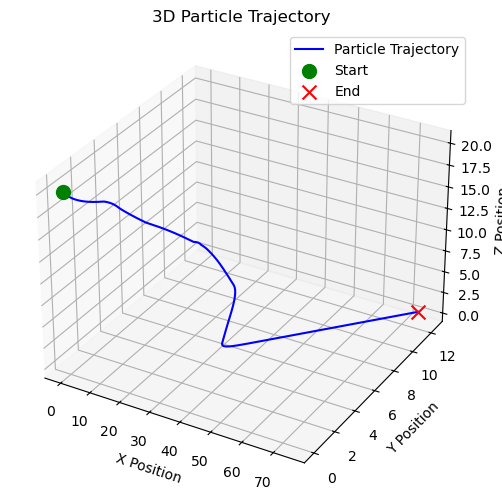

In [7]:
# Extract x, y, z coordinates
x_vals = trajectory[:, 0]  # All rows, first column
y_vals = trajectory[:, 1]  # All rows, second column
z_vals = trajectory[:, 2]  # All rows, third column

# Print start and end positions
print(f"Start Position: x={x_vals[0]}, y={y_vals[0]}, z={z_vals[0]}")
print(f"End Position: x={x_vals[-1]}, y={y_vals[-1]}, z={z_vals[-1]}")

# Create 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
ax.plot(x_vals, y_vals, z_vals, label="Particle Trajectory", color="b")

# Mark start and end points
ax.scatter(x_vals[0], y_vals[0], z_vals[0], color='g', marker='o', s=100, label="Start")  # Green start
ax.scatter(x_vals[-1], y_vals[-1], z_vals[-1], color='r', marker='x', s=100, label="End")  # Red end

# Labels and Title
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Z Position")
ax.set_title("3D Particle Trajectory")

# Show legend
ax.legend()
plt.show()
